In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data

In [7]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

# Simple one-latent function model

        y = f(x) + e
        f = GP(0, RBF)

        l = InvGama()
        sigma = Gamma()

In [3]:
# function to plot results

def plot_distribution(X, Y, mean, var, pos, labels):
    plt.figure(figsize=(25, 7))

    plt.plot(X, Y, '.', color="black", alpha=0.5, markersize=3)
    plt.plot(X, mean, color="C0")
    c = 1.96 * np.sqrt(var)
    plt.fill_between(X[:,0], (mean - c)[:,0], (mean + c)[:,0], alpha=0.2, edgecolor='gray', facecolor='C0')

    plt.xticks(pos, labels)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Normalised Births', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    plt.close()

Epoch 25 - Loss:  4738.0530


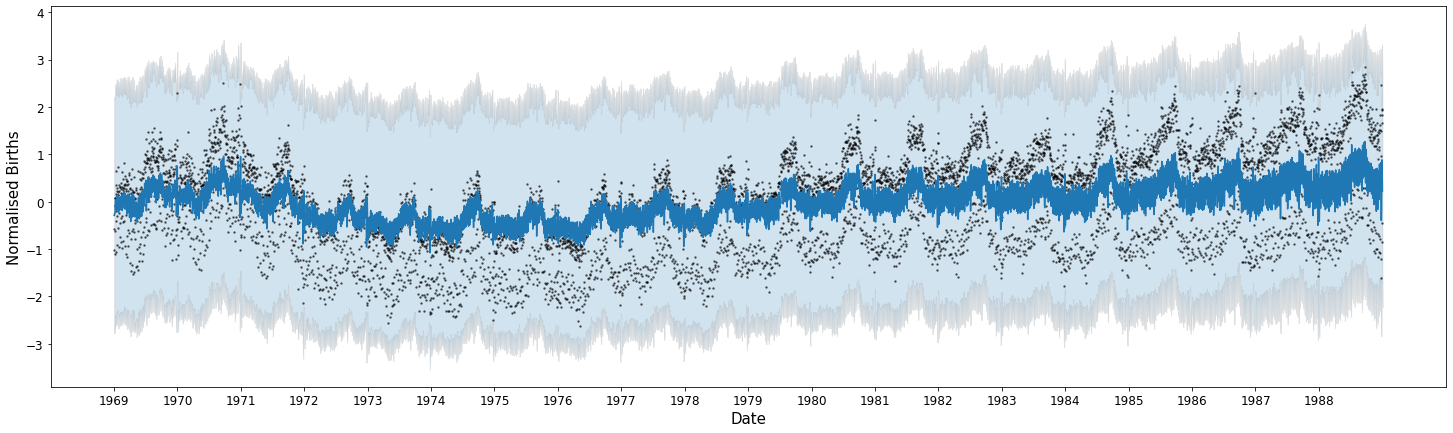

Fitted values MSE:  0.45294772398699656
ELBO:  -4738.05295640714
Epoch 50 - Loss:  4603.2903


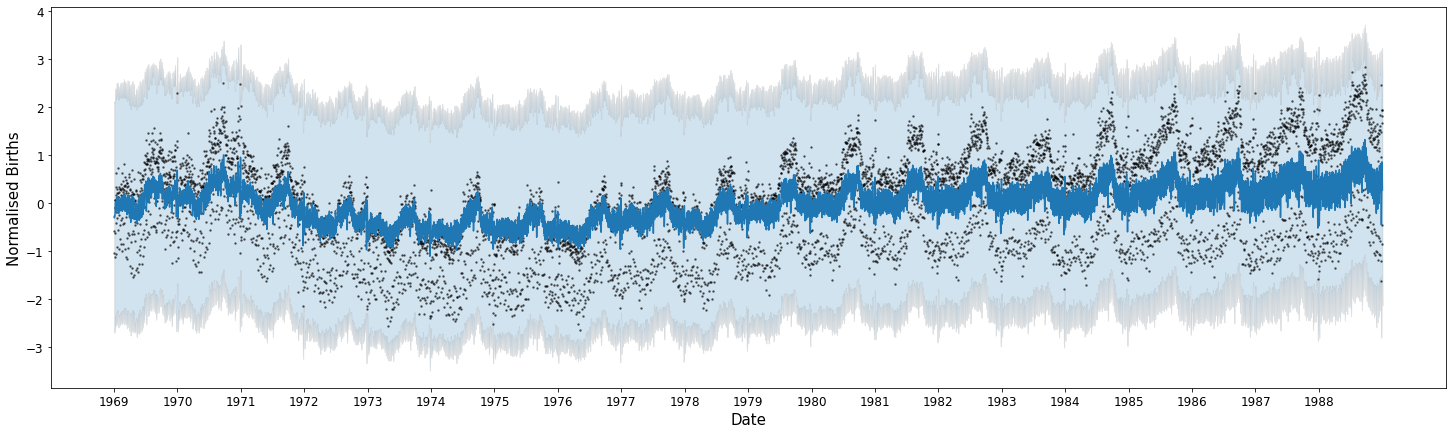

Fitted values MSE:  0.4451658054453016
ELBO:  -4603.290296737387


In [12]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF()
likelihood = gpflow.likelihoods.Gaussian()

M = 3000  
Z = np.linspace(x.numpy().min(), x.numpy().max(), M)[:, None]

#model = gpflow.models.VGP( (x, y), likelihood=gpflow.likelihoods.Gaussian(), kernel=kernel)
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
# model = gpflow.models.SVGP(
#     kernel=kernel,
#     likelihood=likelihood,
#     mean_function=gpflow.mean_functions.Zero(),
#     inducing_variable=Z,
#     num_latent_gps=likelihood.latent_dim,
#     whiten=False
# )

data = (x, y)
loss_fn = model.training_loss_closure(data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)
#set_trainable(model.kernel.kernels[0].kernels[1].period, False)
set_trainable(model.likelihood.variance, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 50
log_freq = 25

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        mean, var = model.predict_y(x)
        #Ymean = Ymean.numpy().squeeze()
        #Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(x, y, mean, var, pos, labels)
        print('Fitted values MSE: ', mean_squared_error(y, mean))
        print('ELBO: ', model.elbo((x,y)).numpy())
        #print(model.maximum_log_likelihood_objective().numpy())

print_summary(model, fmt='notebook')

CI too big?

Add priors to hyperparameters

Epoch 25 - Loss:  4739.4139


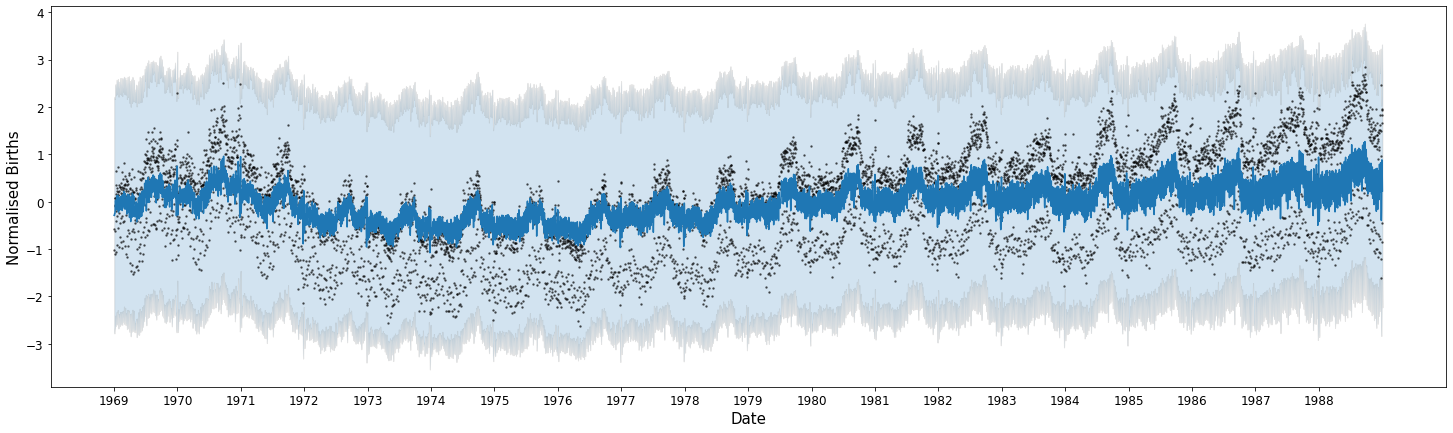

Fitted values MSE:  0.452953722491947
ELBO:  -4738.041529318717
Epoch 50 - Loss:  4604.5353


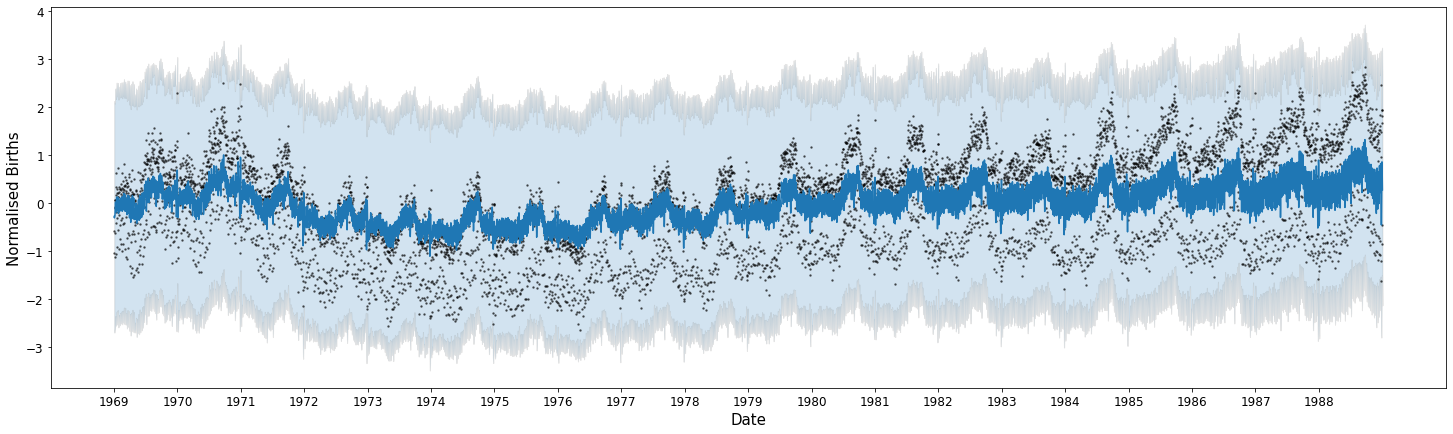

Fitted values MSE:  0.44518807278050043
ELBO:  -4603.273328094826


In [13]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF()
likelihood = gpflow.likelihoods.Gaussian()

M = 3000  
Z = np.linspace(x.numpy().min(), x.numpy().max(), M)[:, None]

model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)

data = (x, y)
loss_fn = model.training_loss_closure(data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)
set_trainable(model.likelihood.variance, False)

# adding priors
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 50
log_freq = 25

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        mean, var = model.predict_y(x)
        #Ymean = Ymean.numpy().squeeze()
        #Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(x, y, mean, var, pos, labels)
        print('Fitted values MSE: ', mean_squared_error(y, mean))
        print('ELBO: ', model.elbo((x,y)).numpy())
        #print(model.maximum_log_likelihood_objective().numpy())

print_summary(model, fmt='notebook')

Change starting conditions

Epoch 25 - Loss:  4296.8695


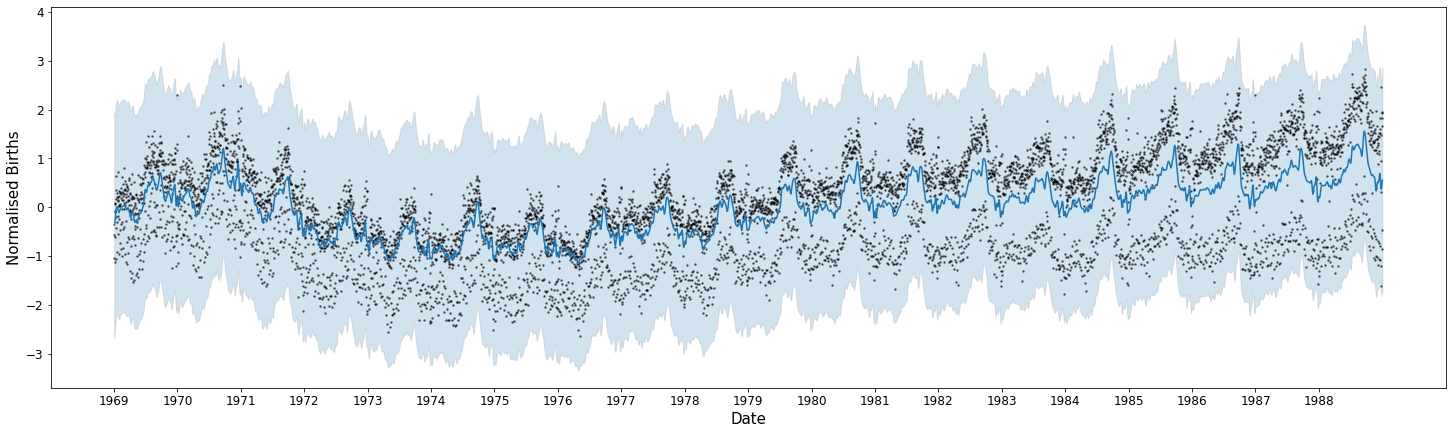

Fitted values MSE:  0.5486517979974698
ELBO:  -4292.968232328029
Epoch 50 - Loss:  4253.9088


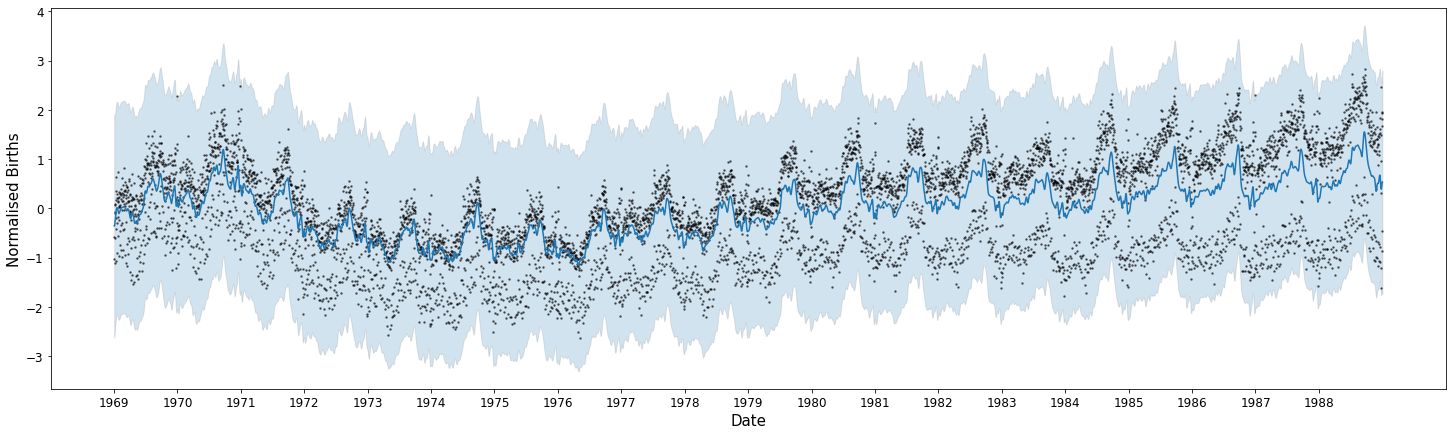

Fitted values MSE:  0.5500028510642093
ELBO:  -4250.082525218106


In [14]:
kernel = gpflow.kernels.RBF(lengthscales=5)
likelihood = gpflow.likelihoods.Gaussian()

M = 3000  
Z = np.linspace(x.numpy().min(), x.numpy().max(), M)[:, None]

model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)

data = (x, y)
loss_fn = model.training_loss_closure(data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)
set_trainable(model.likelihood.variance, False)

# adding priors
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 50
log_freq = 25

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        mean, var = model.predict_y(x)
        #Ymean = Ymean.numpy().squeeze()
        #Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(x, y, mean, var, pos, labels)
        print('Fitted values MSE: ', mean_squared_error(y, mean))
        print('ELBO: ', model.elbo((x,y)).numpy())
        #print(model.maximum_log_likelihood_objective().numpy())

print_summary(model, fmt='notebook')

Again we see these models are sensitive to starting values.

Need to look at train test for fair comparison of which is better.

-------------------------------------------------------------

# Train / Test split: model selection

Assess which kernel helps represent the data best.

    MSE, MAE, Likelihood

Since we have found that the starting point of kernel parameters affects the fit significantly, we will first select the kernel and then run an analysis to find optimal starting conditions for hyperparameters.

In [23]:
def optimise_predict_model(model, M=3000):
    train_data = (x_train, y_train)
    loss_fn = model.training_loss_closure(train_data) 

    gpflow.utilities.set_trainable(model.q_mu, False)
    gpflow.utilities.set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

    epochs = 50
    log_freq = 50

    for epoch in range(1, epochs + 1):
        optimisation_step()

        # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
        if epoch % log_freq == 0 and epoch > 0:
            print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
            mean_train, var_train = model.predict_f(x_train)
            print('Train')
            plot_distribution(x_train, y_train, mean_train, var_train, pos, labels)

    # predict
    mean_test, var_test = model.predict_f(x_test)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))

    print_summary(model, fmt='notebook')

The models consist of a single latent function, untrainable noise variance (justify), hyperparameters with priors.

Epoch 50 - Loss:  4144.7244
Train


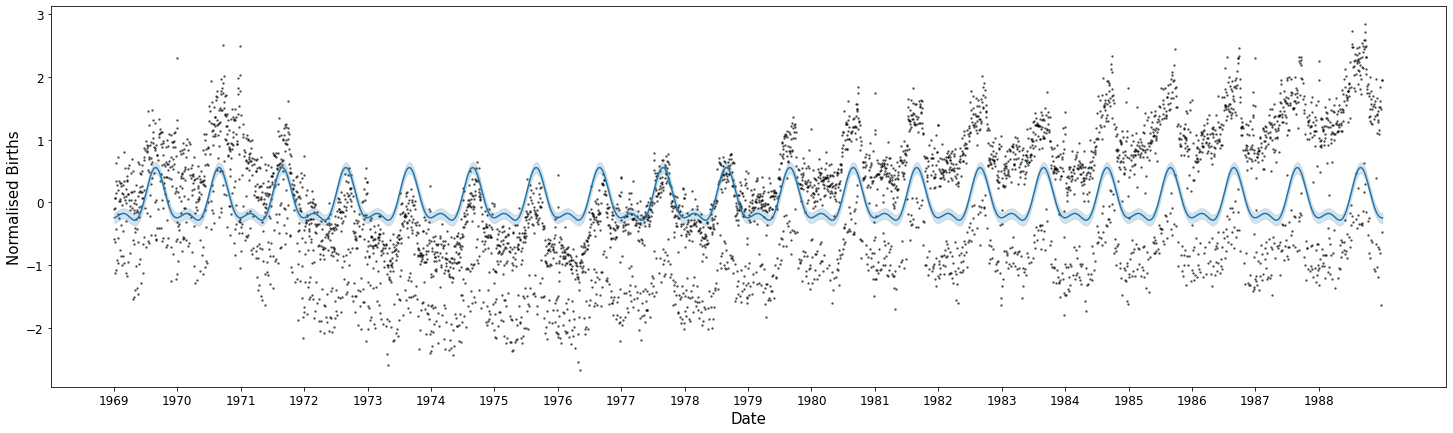

Test


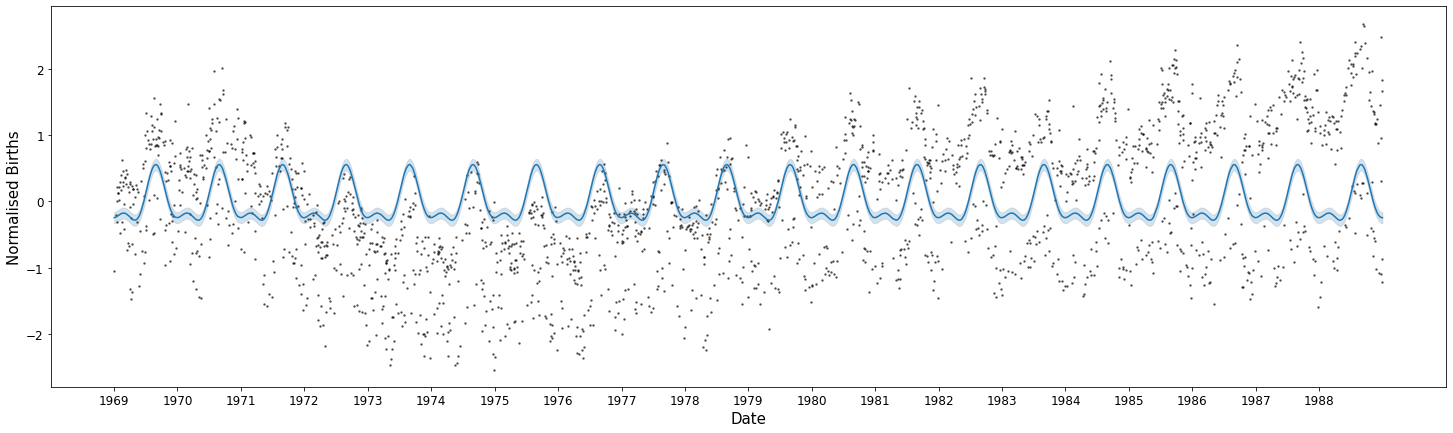

train ELBO, MSE, MAE:  -4143.7459035101165 0.9148080153948241 0.8164123619030597
test ELBO, MSE, MAE:  -4165.410181362453 0.9292450774458814 0.826864210918036


--------------------------------------------------------
Epoch 50 - Loss:  4574.5784
Train


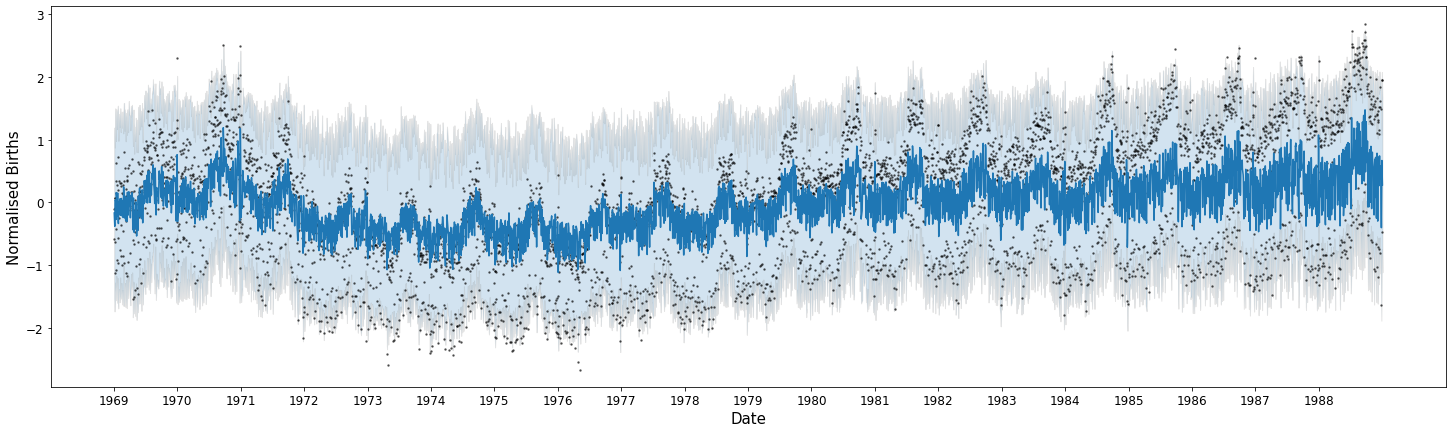

Test


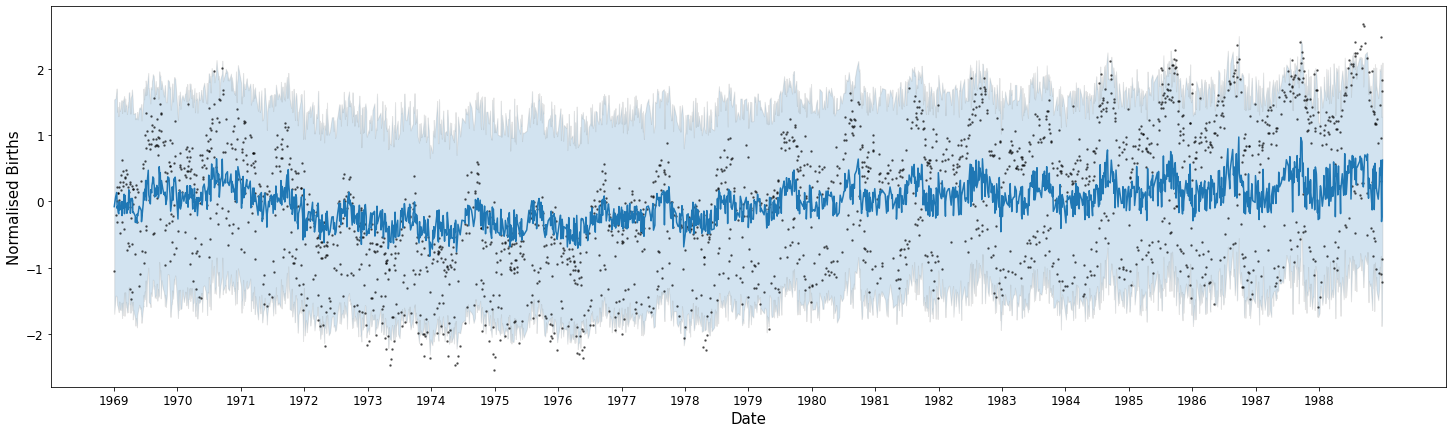

train ELBO, MSE, MAE:  -4572.967116917702 0.411926575303779 0.5376169377894214
test ELBO, MSE, MAE:  -5256.0553250432295 0.7394096843580732 0.7260236730192543


--------------------------------------------------------
Epoch 50 - Loss:  4517.2507
Train


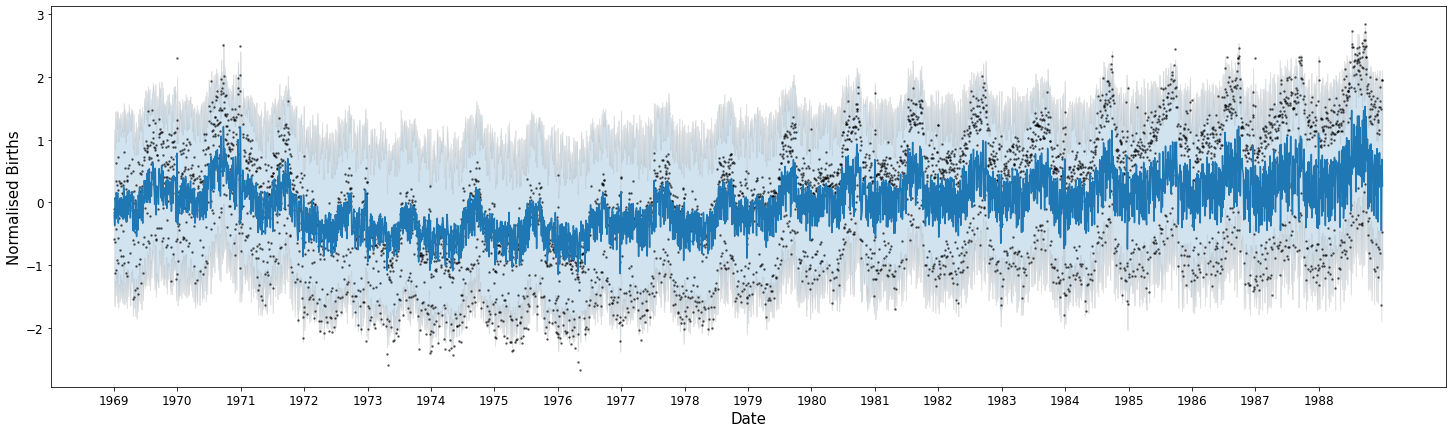

Test


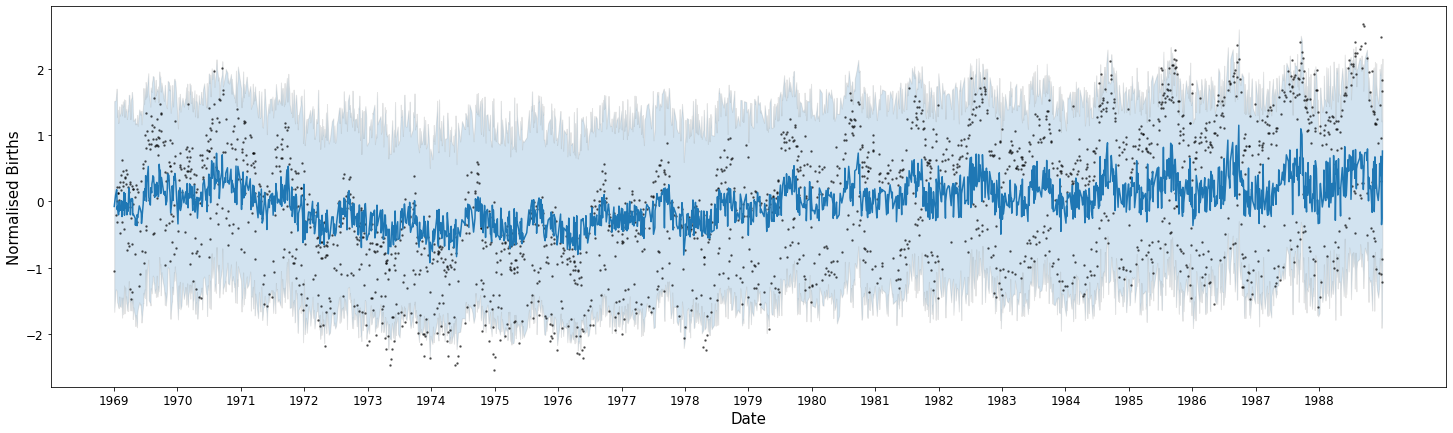

train ELBO, MSE, MAE:  -4515.646150393144 0.3963645564662199 0.5254731665010439
test ELBO, MSE, MAE:  -5195.882097684635 0.7179364604168349 0.7139601748449784


--------------------------------------------------------


In [24]:
# Kernel MODEL SELECTION
kernel_list = [gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25), gpflow.kernels.Matern52(), gpflow.kernels.RBF()]

for i in range(len(kernel_list)):
    print(kernel_list[i])

    kernel = kernel_list[i]

    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)

    if i == 0:
        set_trainable(model.kernel.period, False)
        model.kernel.base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(3), to_default_float(2))
        model.kernel.base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    else:
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(3), to_default_float(2))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    
    optimise_predict_model(model)
    print('--------------------------------------------------------')

The kernel with best performance: RBF. Although, Matern52 performs similar. BUT, the models seem to be overfitting. Maybe lower the epochs...

Now, we would carry out the sensitivity analysis done before but on the train test set.

Starting Values (l, v):  1 1
Epoch 50 - Loss:  4517.7283
Train


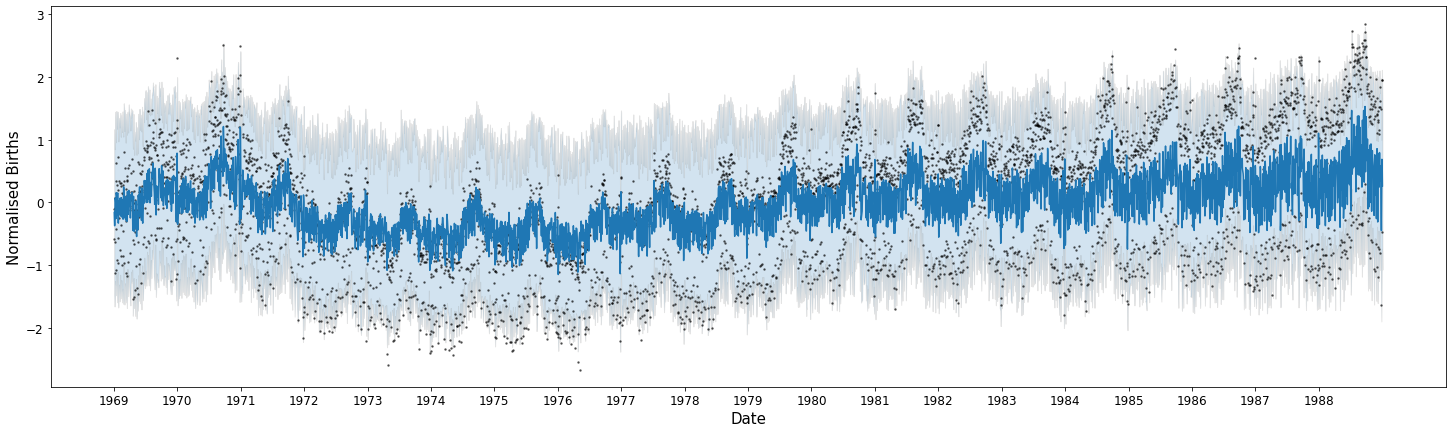

Test


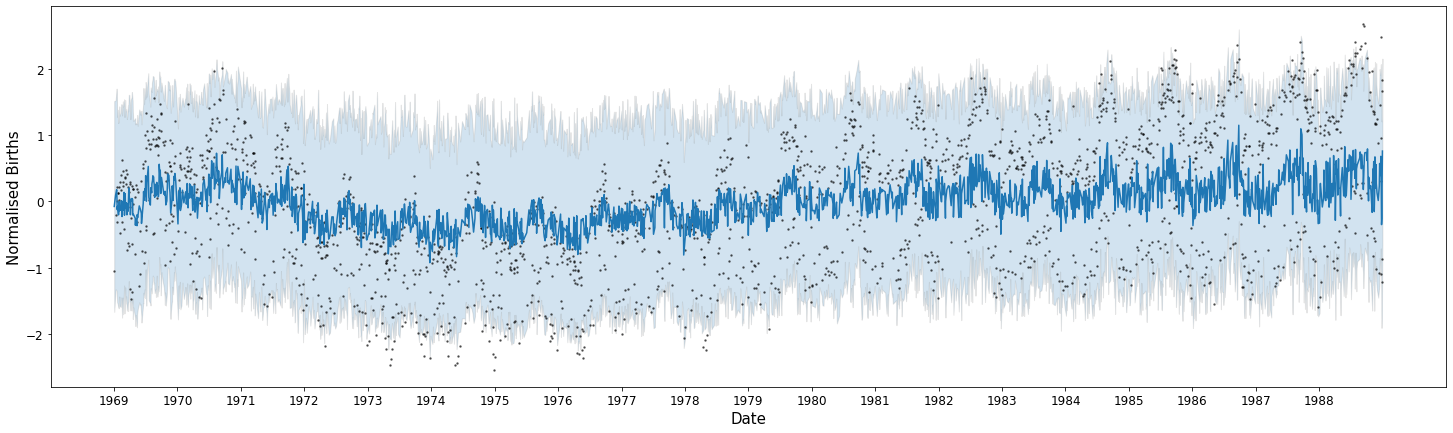

train ELBO, MSE, MAE:  -4515.624772308348 0.3963616270629404 0.5254711303730399
test ELBO, MSE, MAE:  -5195.8444448917235 0.7179266310704205 0.7139553209139362


--------------------------------------------------------
Starting Values (l, v):  5 1
Epoch 50 - Loss:  4218.8861
Train


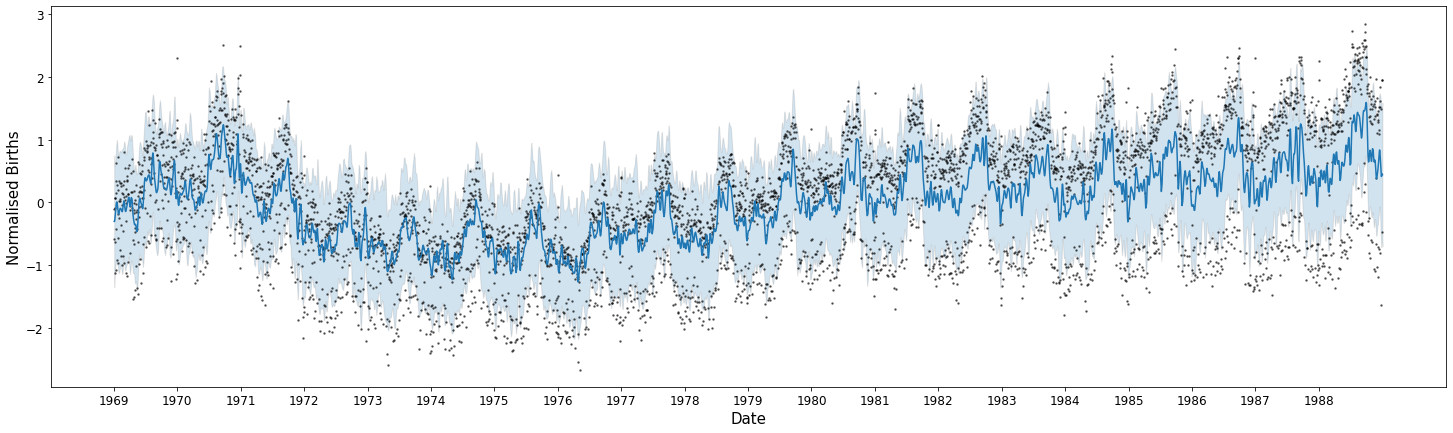

Test


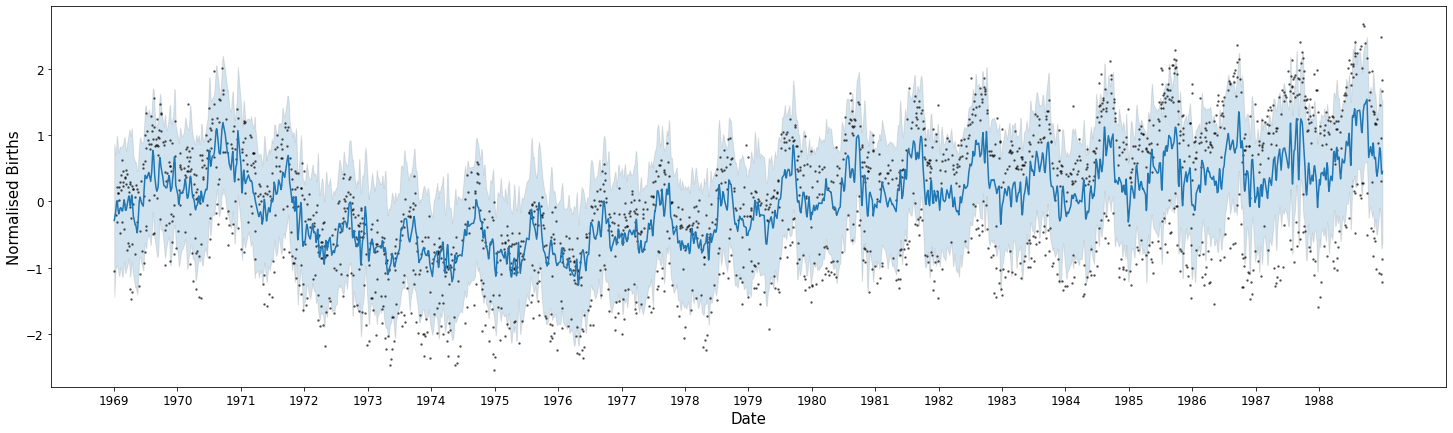

train ELBO, MSE, MAE:  -4215.2011139334545 0.5223393115360271 0.6058988468412954
test ELBO, MSE, MAE:  -4518.188732853362 0.6927887628951789 0.700979943140881


--------------------------------------------------------


In [25]:
starting_values_l = [1, 5]
starting_values_v = [1]

for l in starting_values_l:
    for v in starting_values_v:
        print('Starting Values (l, v): ', l, v)
        kernel = gpflow.kernels.RBF(lengthscales = l, variance = v)
        Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
        model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
        set_trainable(model.likelihood.variance, False)
        
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

        optimise_predict_model(model)
        print('--------------------------------------------------------')

Starting conditions 1,1 seem to be overfitting. 5,1 although has a worse train mse, it is closer to test mse, less overfitting.

Try 1,1 but less epochs.

Starting Values (l, v):  5 1
Epoch 20 - Loss:  4304.0820
Epoch 40 - Loss:  4297.9545
Epoch 60 - Loss:  4294.2117
Epoch 80 - Loss:  4290.3967
Epoch 100 - Loss:  4286.5071
Train


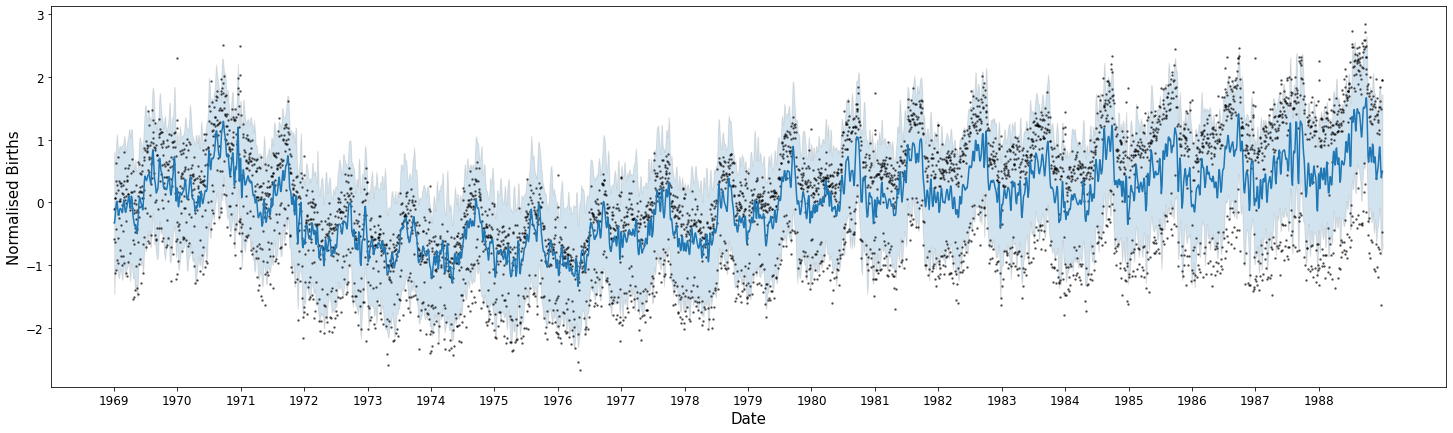

Test


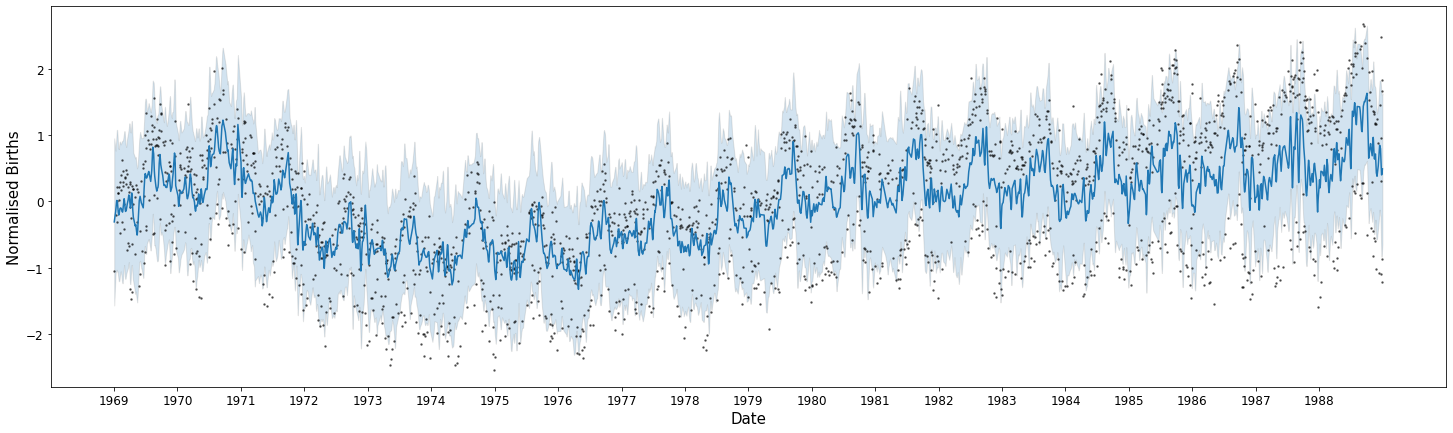

train ELBO, MSE, MAE:  -4282.592070029606 0.5123080636875949 0.5999382419087813
test ELBO, MSE, MAE:  -4632.240846887529 0.7048831289236444 0.7072589966019145


In [ ]:
print('Starting Values (l, v): ', 1, 1)
kernel = gpflow.kernels.RBF(lengthscales = 5, variance = 1)
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model.likelihood.variance, False)
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

train_data = (x_train, y_train)
loss_fn = model.training_loss_closure(train_data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 100
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        if epoch == 100:
            mean_train, var_train = model.predict_f(x_train)
            print('Train')
            plot_distribution(x_train, y_train, mean_train, var_train, pos, labels)

# predict
mean_test, var_test = model.predict_f(x_test)
print('Test')
plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

# evaluate
print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))

print_summary(model, fmt='notebook')